# Duffing — Chaos analysis (Lyapunov and perturbations)
This notebook demonstrates how to estimate a largest Lyapunov exponent, run perturbation tests, and interpret results.

In [6]:
# Notebook-friendly imports: ensure project root is on sys.path so local `duffing` package imports work
import sys, os
# compute project root (one level up from notebooks/)
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from duffing.features import classify_by_lyapunov, estimate_lyapunov_benettin
from duffing.visualize import compute_perturbed_delta
print('numpy', np.__version__)
print('pandas', pd.__version__)

numpy 2.3.3
pandas 2.3.3


In [7]:
# Load a demo CSV (created by notebook 01)
df = pd.read_csv('../demo_small.csv') if False else pd.read_csv('demo_small.csv')
if 'base_id' not in df.columns:
    df['base_id'] = df.groupby(['delta','alpha','beta','omega']).ngroup()
row = df.iloc[5]
params = {k: float(row[k]) for k in ['delta','alpha','beta','omega','gamma']}
print('params:', params)

params: {'delta': 0.2803197311151155, 'alpha': 0.9009273926518706, 'beta': 0.1441596127196337, 'omega': 1.4486494471372438, 'gamma': 1.1}


Selected periodic params: {'delta': 0.2803197311151155, 'alpha': 0.9009273926518706, 'beta': 0.1441596127196337, 'omega': 1.4486494471372438, 'gamma': 0.1}
Selected chaotic params: {'delta': 0.1903241534047184, 'alpha': -0.1533471020548487, 'beta': 0.8277025938204418, 'omega': 0.9091991363691612, 'gamma': 0.1}
Periodic classification (quick): {'lyap': -0.14043628324685892, 'label': 'periodic'}
Chaotic classification (quick): {'lyap': 0.10755991735591294, 'label': 'chaotic'}


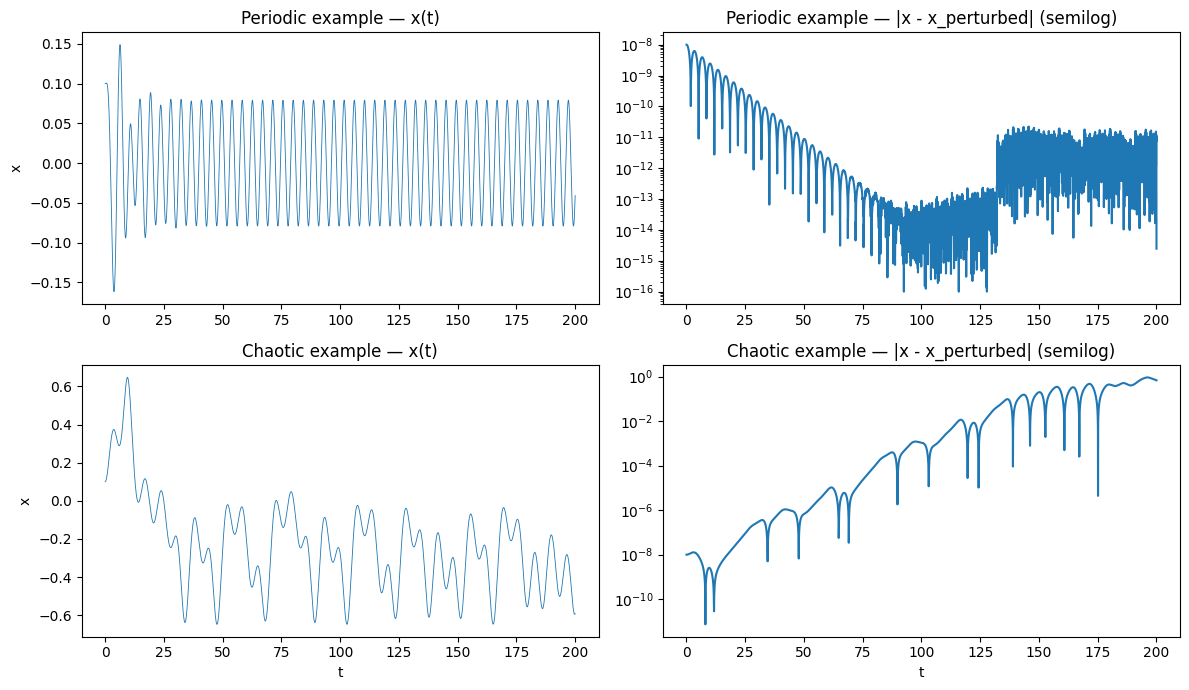

In [14]:
# Select one periodic and one chaotic example from the demo CSV (fast scan)
# Strategy: try to use any existing `periodic` column first. If not available,
# do a quick scan over the first N rows and run a fast Lyapunov-based check to
# find one periodic and one chaotic example. This keeps runtime small while
# producing useful visuals for the notebook.
import numpy as np
import matplotlib.pyplot as plt
from duffing.solver import solve_duffing

# helper to build params dict for functions in this notebook
def row_to_params(row):
    return {k: float(row[k]) for k in ['delta', 'alpha', 'beta', 'omega', 'gamma']}

# ensure df is present (earlier cell normally loads it)
if 'df' not in globals():
    import pandas as pd
    df = pd.read_csv('demo_small.csv')

p_params = None
c_params = None
p_row = None
c_row = None
p_res = None
c_res = None

# 1) Prefer an explicit column if present
if 'periodic' in df.columns:
    periodic_rows = df[df['periodic'] == True]
    nonperiodic_rows = df[df['periodic'] == False]
    if len(periodic_rows) > 0:
        p_row = periodic_rows.iloc[0]
        p_params = row_to_params(p_row)
    if len(nonperiodic_rows) > 0:
        # still verify with a quick lyapunov call below
        c_row = nonperiodic_rows.iloc[0]
        c_params = row_to_params(c_row)

# 2) If we don't already have both, do a quick scan and classify (fast settings)
if p_params is None or c_params is None:
    max_scan = min(50, len(df))
    for idx, row in df.head(max_scan).iterrows():
        params = row_to_params(row)
        # fast, conservative settings to keep this cell interactive
        res = classify_by_lyapunov(params, transient_cycles=8, measure_cycles=40, eps=1e-7, dt_cycles=1)
        if res['label'] == 'periodic' and p_params is None:
            p_params = params
            p_row = row
            p_res = res
        if res['label'] == 'chaotic' and c_params is None:
            c_params = params
            c_row = row
            c_res = res
        if p_params is not None and c_params is not None:
            break

# 3) Last-resort fallback using simple heuristics
if p_params is None or c_params is None:
    if 'dom_freq' in df.columns and 'x_std' in df.columns:
        # pick candidate periodic as highest dom_freq, chaotic as highest x_std
        p_row = df.loc[df['dom_freq'].idxmax()]
        c_row = df.loc[df['x_std'].idxmax()]
        p_params = row_to_params(p_row)
        c_params = row_to_params(c_row)
    elif 'dom_freq' in df.columns:
        p_row = df.loc[df['dom_freq'].idxmax()]
        c_row = df.loc[df['dom_freq'].idxmin()]
        p_params = row_to_params(p_row)
        c_params = row_to_params(c_row)

if p_params is None or c_params is None:
    raise RuntimeError('Could not find both periodic and chaotic examples quickly. Ensure demo_small.csv contains diverse examples or run notebook 01 to regenerate it.')

print('Selected periodic params:', p_params)
print('Selected chaotic params:', c_params)

# (Optional) get a slightly longer Lyapunov estimate for the selected rows for display
try:
    if p_res is None:
        p_res = classify_by_lyapunov(p_params, transient_cycles=20, measure_cycles=80, eps=1e-8, dt_cycles=1)
    if c_res is None:
        c_res = classify_by_lyapunov(c_params, transient_cycles=20, measure_cycles=80, eps=1e-8, dt_cycles=1)
except Exception as e:
    print('Warning: Lyapunov re-check failed:', e)

print('Periodic classification (quick):', p_res)
print('Chaotic classification (quick):', c_res)

# Simulate time series and perturbation growth for both examples
t_span = (0.0, 200.0)
# use a reasonably fine eval grid for plotting
t_eval = np.linspace(t_span[0], t_span[1], 5000)
sol_p = solve_duffing(t_span, (0.1, 0.0), p_params, t_eval=t_eval)
sol_c = solve_duffing(t_span, (0.1, 0.0), c_params, t_eval=t_eval)

# compute perturbed delta (Benettin-style difference) for visualization
# compute_perturbed_delta returns (t, delta)
t_p, delta_p = compute_perturbed_delta(p_params, t_span=t_span, y0=(0.1, 0.0), eps=1e-8)
t_c, delta_c = compute_perturbed_delta(c_params, t_span=t_span, y0=(0.1, 0.0), eps=1e-8)

# 2x2 plot: rows = periodic / chaotic, cols = time series / perturbation growth
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

axs[0, 0].plot(sol_p.t, sol_p.y[0], lw=0.6)
axs[0, 0].set_title('Periodic example — x(t)')
axs[0, 0].set_ylabel('x')

axs[0, 1].semilogy(t_p, np.clip(delta_p, 1e-16, None))
axs[0, 1].set_title('Periodic example — |x - x_perturbed| (semilog)')

axs[1, 0].plot(sol_c.t, sol_c.y[0], lw=0.6)
axs[1, 0].set_title('Chaotic example — x(t)')
axs[1, 0].set_xlabel('t')
axs[1, 0].set_ylabel('x')

axs[1, 1].semilogy(t_c, np.clip(delta_c, 1e-16, None))
axs[1, 1].set_title('Chaotic example — |x - x_perturbed| (semilog)')
axs[1, 1].set_xlabel('t')

plt.tight_layout()
plt.show()

In [9]:
# Classify via Lyapunov estimator (this can be slow)
res = classify_by_lyapunov(params, transient_cycles=30, measure_cycles=120, eps=1e-8, dt_cycles=1)
print(res)

{'lyap': -0.1403655193329439, 'label': 'periodic'}


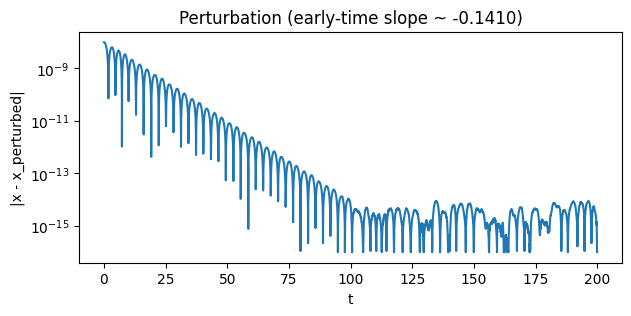

In [10]:
# Perturbation test and semilog plot (visual)
t, delta = compute_perturbed_delta(params, t_span=(0,200), y0=(0.1,0.0), eps=1e-8)
plt.figure(figsize=(7,3))
plt.semilogy(t, np.clip(delta, 1e-16, None))
plt.xlabel('t'); plt.ylabel('|x - x_perturbed|')
# Fit early-time slope for approximate lyapunov number
mask = (t>0) & (t<50)
if np.any(mask):
    coeffs = np.polyfit(t[mask], np.log(np.clip(delta[mask],1e-16,None)), 1)
    lyap_est = coeffs[0]
    plt.title(f'Perturbation (early-time slope ~ {lyap_est:.4f})')
else:
    plt.title('Perturbation (no early window)')
plt.show()

## Notes:
- `classify_by_lyapunov` uses a Benettin-style estimator and can be slow for long measure_cycles.
- Tune `eps`, `transient_cycles`, and `measure_cycles` to improve stability of the estimate.
- Use the perturbation semilog plot to visually assess exponential growth/decay before trusting numeric LLE.

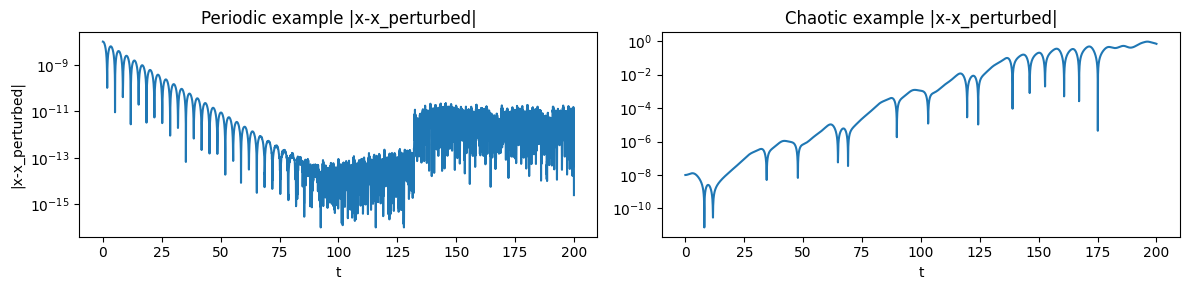

In [11]:
# Compare perturbation growth for periodic vs chaotic example side-by-side
# NOTE: compute_perturbed_delta and the params (p_params, c_params) should be defined in earlier cells.
# If not, define or re-run previous cells that compute/select p_params and c_params.

# Run the perturbation simulations (these can take a few seconds)
t_p, delta_p = compute_perturbed_delta(p_params, t_span=(0,200), y0=(0.1,0.0), eps=1e-8)
t_c, delta_c = compute_perturbed_delta(c_params, t_span=(0,200), y0=(0.1,0.0), eps=1e-8)

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(12,3))
axs[0].semilogy(t_p, np.clip(delta_p, 1e-16, None))
axs[0].set_title('Periodic example |x-x_perturbed|')
axs[0].set_xlabel('t'); axs[0].set_ylabel('|x-x_perturbed|')
axs[1].semilogy(t_c, np.clip(delta_c, 1e-16, None))
axs[1].set_title('Chaotic example |x-x_perturbed|')
axs[1].set_xlabel('t')
plt.tight_layout()
plt.show()